# Volatility Research

For this research we will use two groups of random datasets, focusing first on OHLCV for a select US equity and then on a cryptocurrency.

We've decided to first look into Delta Air Lines(DAL), because of the opportunity to look into changing regimes and a stock with not necessarily optimal growth on multiple time horizons

For the cryptocurrency we will be looking into Bitcoin, as it is the cryptocurrency with most historical data.

In [2]:
import ccxt
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timezone
import matplotlib.pyplot as plt

## Data

### DAL-code

In [127]:
dal_df = yf.download("DAL", start="2000-01-01", end="2025-01-01")
dal_1m_df = yf.download("DAL", interval="1m", period="7d")

C:\Users\Mark Brezina\AppData\Local\Temp\ipykernel_20420\2700557264.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dal_df = yf.download("DAL", start="2000-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed
C:\Users\Mark Brezina\AppData\Local\Temp\ipykernel_20420\2700557264.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dal_1m_df = yf.download("DAL", interval="1m", period="7d")
[*********************100%***********************]  1 of 1 completed


### BTC-code

In [3]:
EXCHANGE_MAP = {
    "binance": ccxt.binance,
    "kraken": ccxt.kraken,
    "gemini": ccxt.gemini,
    "coinbase": ccxt.coinbase,  # ccxt "coinbase" is Coinbase Exchange (Advanced Trade)
}

def get_exchange(name: str):
    name = name.lower().strip()
    if name not in EXCHANGE_MAP:
        raise ValueError(f"Unknown exchange '{name}'. Choose: {list(EXCHANGE_MAP.keys())}")
    ex = EXCHANGE_MAP[name]({"enableRateLimit": True})
    ex.load_markets()
    return ex

def fetch_ohlcv_history(exchange_name: str, symbol: str, timeframe: str, since_iso: str, max_bars: int = 10000):
    ex = get_exchange(exchange_name)
    since_ms = ex.parse8601(since_iso)

    all_rows = []
    while len(all_rows) < max_bars:
        batch = ex.fetch_ohlcv(symbol, timeframe=timeframe, since=since_ms, limit=1000)
        if not batch:
            break
        all_rows.extend(batch)
        since_ms = batch[-1][0] + 1  # move forward 1ms to avoid duplicates

        # safety: stop if exchange keeps returning same last timestamp
        if len(batch) < 2:
            break

    df = pd.DataFrame(all_rows, columns=["timestamp_ms","open","high","low","close","volume"])
    df["timestamp"] = pd.to_datetime(df["timestamp_ms"], unit="ms", utc=True)
    df = df.drop(columns=["timestamp_ms"]).drop_duplicates(subset=["timestamp"]).sort_values("timestamp")
    return df[["timestamp","open","high","low","close","volume"]]


def fetch_spot_price(exchange_name: str, symbol: str):
    ex = get_exchange(exchange_name)
    t = ex.fetch_ticker(symbol)
    # ticker fields vary a bit; 'last' is usually the spot last traded price
    return {
        "exchange": exchange_name,
        "symbol": symbol,
        "timestamp": datetime.fromtimestamp(t["timestamp"]/1000, tz=timezone.utc) if t.get("timestamp") else None,
        "last": t.get("last"),
        "bid": t.get("bid"),
        "ask": t.get("ask"),
        "quoteVolume": t.get("quoteVolume"),
    }

def fetch_ohlcv(exchange_name: str, symbol: str, timeframe: str = "1h", limit: int = 500):
    """
    Returns a DataFrame with columns: timestamp, open, high, low, close, volume (UTC)
    """
    ex = get_exchange(exchange_name)

    # Some exchanges use different symbol formats. We'll check it's listed.
    if symbol not in ex.markets:
        # quick heuristic alternatives
        raise ValueError(
            f"Symbol '{symbol}' not found on {exchange_name}. "
            f"Try exchange-specific formats (e.g. Kraken: 'BTC/USD' or 'XBT/USD')."
        )

    ohlcv = ex.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)
    df = pd.DataFrame(ohlcv, columns=["timestamp_ms", "open", "high", "low", "close", "volume"])
    df["timestamp"] = pd.to_datetime(df["timestamp_ms"], unit="ms", utc=True)
    df = df.drop(columns=["timestamp_ms"])
    return df[["timestamp", "open", "high", "low", "close", "volume"]]


In [87]:
btc_df = yf.download("BTC-USD", start="2000-01-01", end="2025-01-01")
btc_1m_df = fetch_ohlcv_history(exchange_name = "coinbase", symbol = "BTC/USD", timeframe = "1m", since_iso = "2025-01-22T00:00:00Z", max_bars = 10000)

C:\Users\Mark Brezina\AppData\Local\Temp\ipykernel_20420\723773535.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc_df = yf.download("BTC-USD", start="2000-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


## Features and basic analysis

Since we will be looking into volatility, it is obvious that we will first implement these features onto our data and then derive additional features of relevance.

1. Returns
2. price-volatility - meaning a rolling standard deviation of prices
3. returns-volatility - meaning a rolling standard deviation of returns
4. D1 of price-volatility - meaning the first differential of price-volatility
5. D1 of returns-volatility - meaning the first differential of returns-volatility

Why do we believe these features are of relevance?

In [ ]:
df['log_return'] = np.log(df['Price'] / df['Price'].shift(1))

# volatility indicators

df['daily_vol'] = df['log_return'].rolling(window=21).std()
df['ewma_vol'] = df['log_return'].ewm(span=21, adjust=False).std()
# linear regression on volatility
df["vol_slope"] = rolling_linreg_slope(df["ewma_vol"], window=21)
# first and second derivative of volatility
df["Dvol"] = (df['ewma_vol'] - df['ewma_vol'].shift(1))
df["D2vol"] = (df['Dvol'] - df['Dvol'].shift(1))
#volatility of volatility
df["vov"] = df['ewma_vol'].ewm(span=21, adjust=False).std()
#slope of vov
df["vov_slope"] = rolling_linreg_slope(df["vov"], window=21)

df["log_vol"] = np.log(df["ewma_vol"])
z_vol = (df["log_vol"] - df["log_vol"].ewm(span=21, adjust=False).mean()) / df["log_vol"].ewm(span=21, adjust=False).std()

df["vol_sign1"] = df['ewma_vol'].rolling(window=21).min()
df["vol_sign2"] = df['ewma_vol'].rolling(window=21).max()

### dal-historical data

In [128]:
dal_df.columns = dal_df.columns.droplevel(1)
dal_df["log_p"] = np.log(dal_df["Close"])
# Price volatility
dal_df['Pvol'] = dal_df['log_p'].rolling(window=21).std()
dal_df['PEvol'] = dal_df['Close'].ewm(span=21, adjust=False).std()
# Returns and returns volatility
dal_df["Returns"] = (dal_df['Close'] / dal_df['Close'].shift(1)) - 1
dal_df['Rvol'] = dal_df['Returns'].rolling(window=21).std()
dal_df['REvol'] = dal_df['Returns'].ewm(span=21, adjust=False).std()
# D1 of price-volatility
dal_df["DPvol"] = (dal_df['Pvol'] - dal_df['Pvol'].shift(1))/dal_df['Pvol'].shift(1)
# D1 of returns-volatility
dal_df["DRvol"] = (dal_df['Rvol'] - dal_df['Rvol'].shift(1))/dal_df['Rvol'].shift(1)

#dal_df["D2vol"] = (dal_df['Dvol'] - dal_df['Dvol'].shift(1))

#### plots

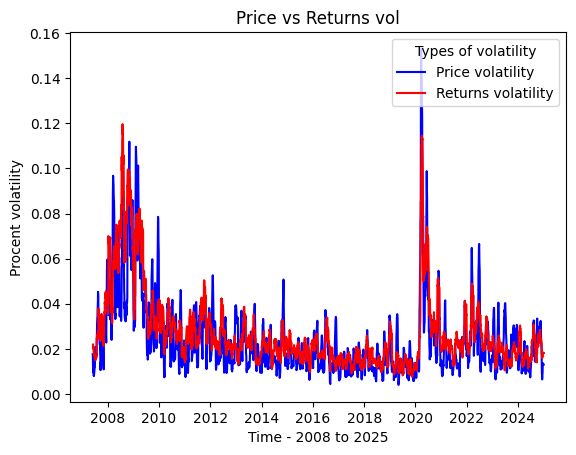

In [105]:
plt.plot(dal_df.Pvol/2, label = "Price volatility", color = "blue")
plt.plot(dal_df.Rvol, label = "Returns volatility", color = "red")
plt.title("Price vs Returns vol")
plt.ylabel("Procent volatility")
plt.xlabel("Time - 2008 to 2025")
plt.legend(title="Types of volatility", loc="upper right")
plt.show()

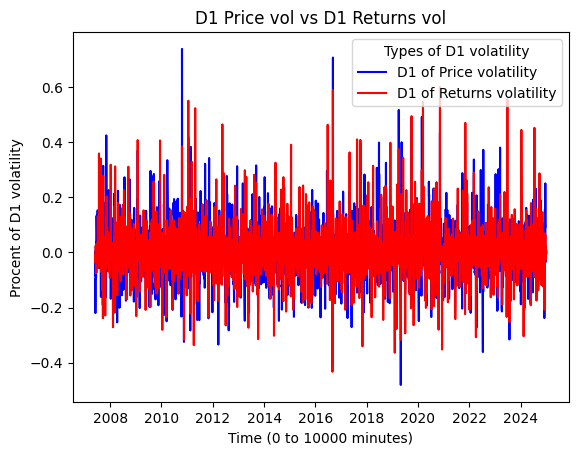

In [59]:
plt.plot(dal_df.DPvol, label = "D1 of Price volatility", color = "blue")
plt.plot(dal_df.DRvol, label = "D1 of Returns volatility", color = "red")
plt.title("D1 Price vol vs D1 Returns vol")
plt.ylabel("Procent of D1 volatility")
plt.xlabel("Time (0 to 10000 minutes)")
plt.legend(title="Types of D1 volatility", loc="upper right")
plt.show()

### dal 1 minute data

In [129]:
dal_1m_df.columns = dal_1m_df.columns.droplevel(1)
# Price volatility
dal_1m_df['Pvol'] = dal_1m_df['Close'].rolling(window=21).std()
dal_1m_df['PEvol'] = dal_1m_df['Close'].ewm(span=21, adjust=False).std()
# Returns and returns volatility
dal_1m_df["Returns"] = (dal_1m_df['Close'] / dal_1m_df['Close'].shift(1)) - 1
dal_1m_df['Rvol'] = dal_1m_df['Returns'].rolling(window=21).std()
dal_1m_df['REvol'] = dal_1m_df['Returns'].ewm(span=21, adjust=False).std()
# D1 of price-volatility
dal_1m_df["DPvol"] = (dal_1m_df['Pvol'] - dal_1m_df['Pvol'].shift(1))/dal_1m_df['Pvol'].shift(1)
# D1 of returns-volatility
dal_1m_df["DRvol"] = (dal_1m_df['Rvol'] - dal_1m_df['Rvol'].shift(1))/dal_1m_df['Rvol'].shift(1)
dal_1m_df = dal_1m_df.reset_index(drop=True)
#dal_df["D2vol"] = (dal_df['Dvol'] - dal_df['Dvol'].shift(1))

#### plots

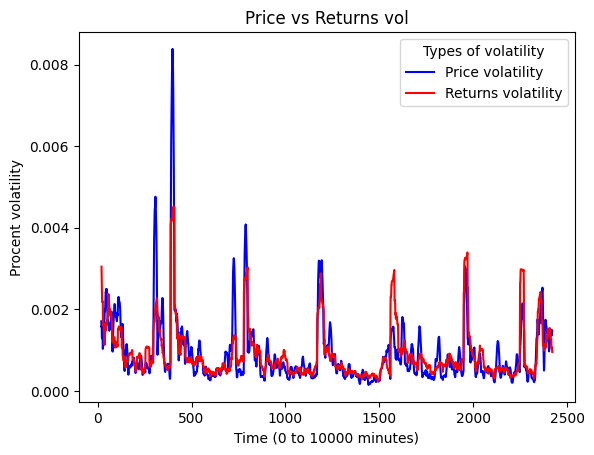

In [53]:
plt.plot(dal_1m_df.Pvol/111.98, label = "Price volatility", color = "blue")
plt.plot(dal_1m_df.Rvol, label = "Returns volatility", color = "red")
plt.title("Price vs Returns vol")
plt.ylabel("Procent volatility")
plt.xlabel("Time (0 to 10000 minutes)")
plt.legend(title="Types of volatility", loc="upper right")
plt.show()

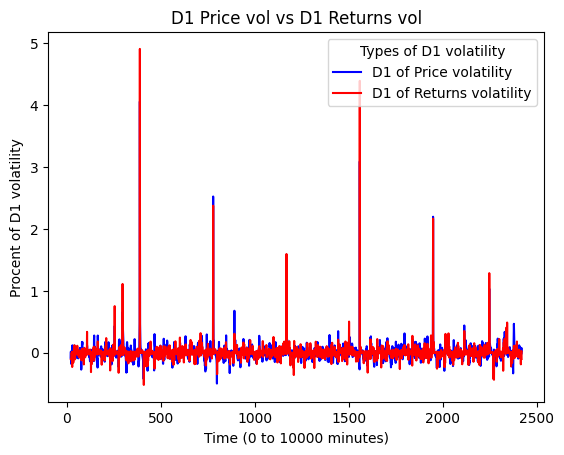

In [54]:
plt.plot(dal_1m_df.DPvol, label = "D1 of Price volatility", color = "blue")
plt.plot(dal_1m_df.DRvol, label = "D1 of Returns volatility", color = "red")
plt.title("D1 Price vol vs D1 Returns vol")
plt.ylabel("Procent of D1 volatility")
plt.xlabel("Time (0 to 10000 minutes)")
plt.legend(title="Types of D1 volatility", loc="upper right")
plt.show()

### BTC-historical data

In [88]:
btc_df.columns = btc_df.columns.droplevel(1)
btc_df["log_p"] = np.log(btc_df["Close"])
# Price volatility
btc_df['Pvol'] = btc_df['log_p'].rolling(window=21).std()
btc_df['PEvol'] = btc_df['Close'].ewm(span=21, adjust=False).std()
# Returns and returns volatility
btc_df["Returns"] = (btc_df['Close'] / btc_df['Close'].shift(1)) - 1
btc_df['Rvol'] = btc_df['Returns'].rolling(window=21).std()
btc_df['REvol'] = btc_df['Returns'].ewm(span=21, adjust=False).std()
# D1 of price-volatility
btc_df["DPvol"] = (btc_df['Pvol'] - btc_df['Pvol'].shift(1))/btc_df['Pvol'].shift(1)
# D1 of returns-volatility
btc_df["DRvol"] = (btc_df['Rvol'] - btc_df['Rvol'].shift(1))/btc_df['Rvol'].shift(1)

#dal_df["D2vol"] = (dal_df['Dvol'] - dal_df['Dvol'].shift(1))

#### plots

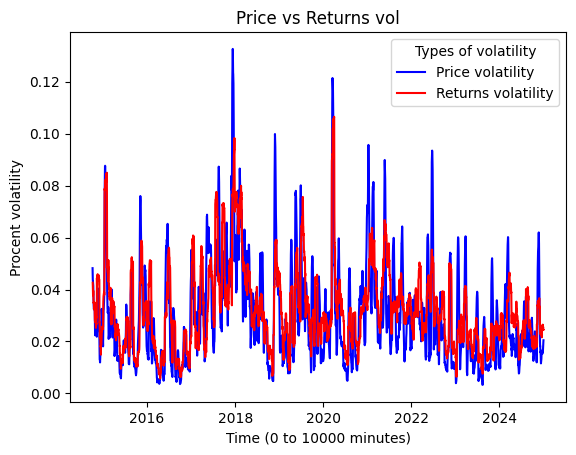

In [92]:
plt.plot(btc_df.Pvol/2, label = "Price volatility", color = "blue")
plt.plot(btc_df.Rvol, label = "Returns volatility", color = "red")
plt.title("Price vs Returns vol")
plt.ylabel("Procent volatility")
plt.xlabel("Time (0 to 10000 minutes)")
plt.legend(title="Types of volatility", loc="upper right")
plt.show()
#plt.plot(btc_1m_df.DRvol)

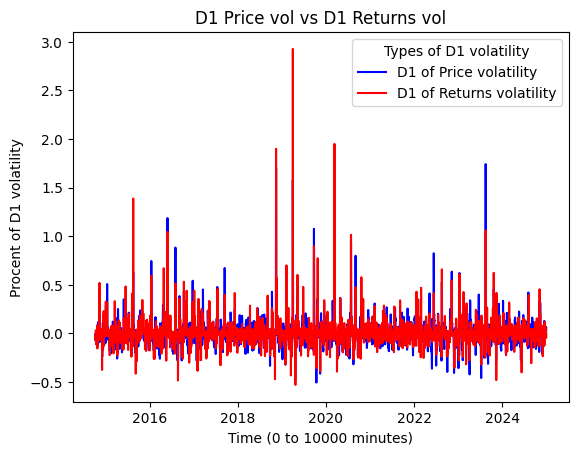

In [94]:
plt.plot(btc_df.DPvol, label = "D1 of Price volatility", color = "blue")
plt.plot(btc_df.DRvol, label = "D1 of Returns volatility", color = "red")
plt.title("D1 Price vol vs D1 Returns vol")
plt.ylabel("Procent of D1 volatility")
plt.xlabel("Time (0 to 10000 minutes)")
plt.legend(title="Types of D1 volatility", loc="upper right")
plt.show()
#plt.plot(btc_1m_df.DRvol)

### BTC 1 minute data

In [99]:
btc_1m_df
# Price volatility
btc_1m_df['Pvol'] = btc_1m_df['close'].rolling(window=21).std()
btc_1m_df['PEvol'] = btc_1m_df['close'].ewm(span=21, adjust=False).std()
# Returns and returns volatility
btc_1m_df["Returns"] = (btc_1m_df['close'] / btc_1m_df['close'].shift(1)) - 1
btc_1m_df['Rvol'] = btc_1m_df['Returns'].rolling(window=21).std()
btc_1m_df['REvol'] = btc_1m_df['Returns'].ewm(span=21, adjust=False).std()
# D1 of price-volatility
btc_1m_df["DPvol"] = (btc_1m_df['Pvol'] - btc_1m_df['Pvol'].shift(1))/btc_1m_df['Pvol'].shift(1)
# D1 of returns-volatility
btc_1m_df["DRvol"] = (btc_1m_df['Rvol'] - btc_1m_df['Rvol'].shift(1))/btc_1m_df['Rvol'].shift(1)

#dal_df["D2vol"] = (dal_df['Dvol'] - dal_df['Dvol'].shift(1))

#### plots

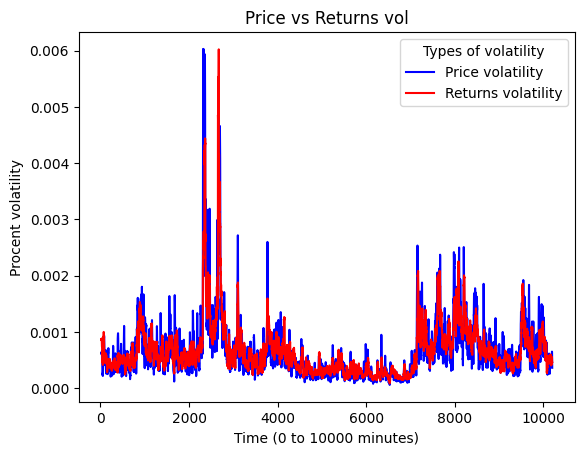

In [33]:
plt.plot(btc_1m_df.Pvol/177809, label = "Price volatility", color = "blue")
plt.plot(btc_1m_df.Rvol, label = "Returns volatility", color = "red")
plt.title("Price vs Returns vol")
plt.ylabel("Procent volatility")
plt.xlabel("Time (0 to 10000 minutes)")
plt.legend(title="Types of volatility", loc="upper right")
plt.show()
#plt.plot(btc_1m_df.DRvol)

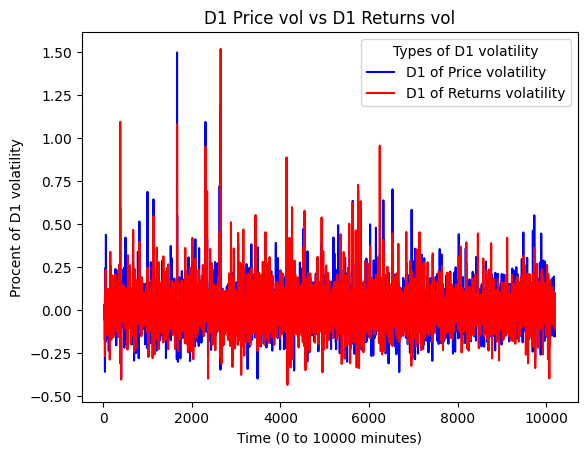

In [38]:
plt.plot(btc_1m_df.DPvol, label = "D1 of Price volatility", color = "blue")
plt.plot(btc_1m_df.DRvol, label = "D1 of Returns volatility", color = "red")
plt.title("D1 Price vol vs D1 Returns vol")
plt.ylabel("Procent of D1 volatility")
plt.xlabel("Time (0 to 10000 minutes)")
plt.legend(title="Types of D1 volatility", loc="upper right")
plt.show()

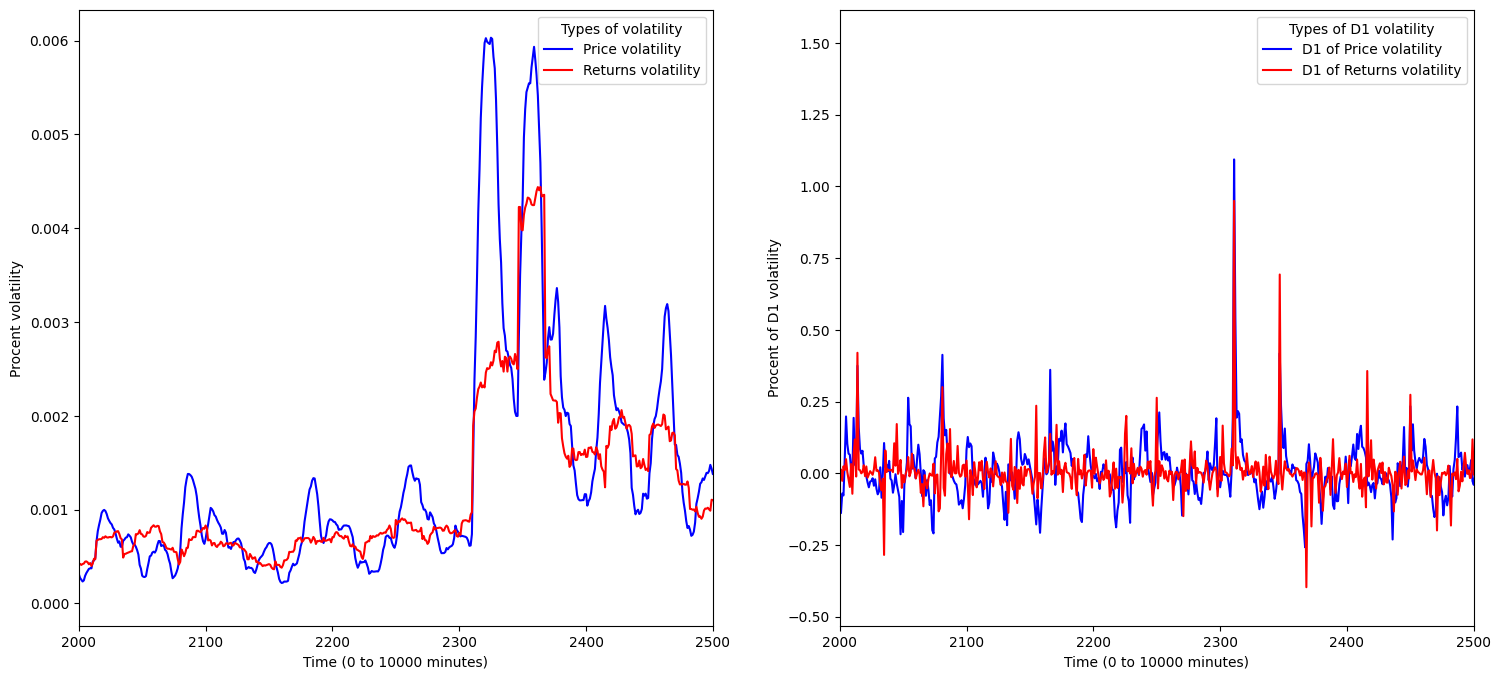

In [120]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

axs[0].plot(btc_1m_df.Pvol/177809, label = "Price volatility", color = "blue")
axs[0].plot(btc_1m_df.Rvol, label = "Returns volatility", color = "red")
#axs[0].suptitle("Price vs Returns vol")
axs[0].set_ylabel("Procent volatility")
axs[0].set_xlabel("Time (0 to 10000 minutes)")
axs[0].legend(title="Types of volatility", loc="upper right")
axs[0].set_xlim(2000,2500)


axs[1].plot(btc_1m_df.DPvol, label = "D1 of Price volatility", color = "blue")
axs[1].plot(btc_1m_df.DRvol, label = "D1 of Returns volatility", color = "red")
#axs[1].suptitle("D1 Price vol vs D1 Returns vol")
axs[1].set_ylabel("Procent of D1 volatility")
axs[1].set_xlabel("Time (0 to 10000 minutes)")
axs[1].legend(title="Types of D1 volatility", loc="upper right")
axs[1].set_xlim(2000,2500)


plt.show()

## Central plot

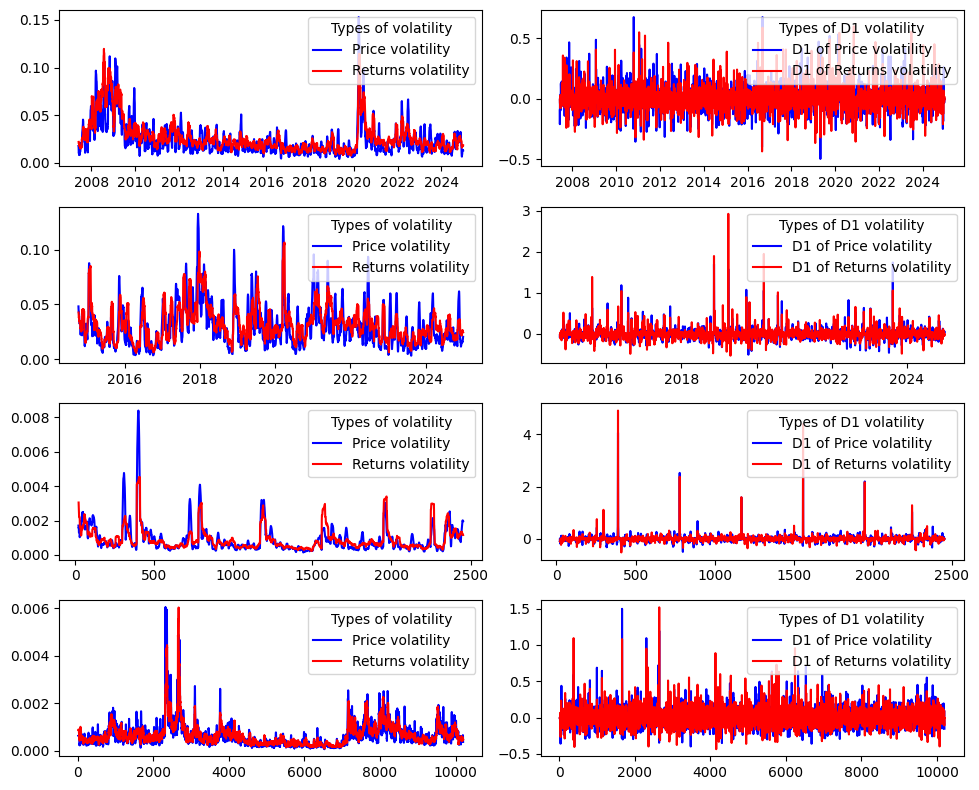

In [108]:
fig, axs = plt.subplots(4, 2, figsize=(10, 8))

# DAL hist D1
axs[0, 0].plot(dal_df.Pvol/2, label = "Price volatility", color = "blue")
axs[0, 0].plot(dal_df.Rvol, label = "Returns volatility", color = "red")
axs[0, 0].legend(title="Types of volatility", loc="upper right")

# BTC hist D1
axs[1, 0].plot(btc_df.Pvol/2, label = "Price volatility", color = "blue")
axs[1, 0].plot(btc_df.Rvol, label = "Returns volatility", color = "red")
axs[1, 0].legend(title="Types of volatility", loc="upper right")

# DAL 1m D1
axs[2, 0].plot(dal_1m_df.Pvol/111.98, label = "Price volatility", color = "blue")
axs[2, 0].plot(dal_1m_df.Rvol, label = "Returns volatility", color = "red")
axs[2, 0].legend(title="Types of volatility", loc="upper right")

# BTC 1m D1
axs[3, 0].plot(btc_1m_df.Pvol/177809, label = "Price volatility", color = "blue")
axs[3, 0].plot(btc_1m_df.Rvol, label = "Returns volatility", color = "red")
axs[3, 0].legend(title="Types of volatility", loc="upper right")


# DAL hist D1
axs[0, 1].plot(dal_df.DPvol, label = "D1 of Price volatility", color = "blue")
axs[0, 1].plot(dal_df.DRvol, label = "D1 of Returns volatility", color = "red")
axs[0, 1].legend(title="Types of D1 volatility", loc="upper right")

# BTC hist D1
axs[1, 1].plot(btc_df.DPvol, label = "D1 of Price volatility", color = "blue")
axs[1, 1].plot(btc_df.DRvol, label = "D1 of Returns volatility", color = "red")
axs[1, 1].legend(title="Types of D1 volatility", loc="upper right")

# DAL 1m D1
axs[2, 1].plot(dal_1m_df.DPvol, label = "D1 of Price volatility", color = "blue")
axs[2, 1].plot(dal_1m_df.DRvol, label = "D1 of Returns volatility", color = "red")
axs[2, 1].legend(title="Types of D1 volatility", loc="upper right")

# BTC 1m D1
axs[3, 1].plot(btc_1m_df.DPvol, label = "D1 of Price volatility", color = "blue")
axs[3, 1].plot(btc_1m_df.DRvol, label = "D1 of Returns volatility", color = "red")
axs[3, 1].legend(title="Types of D1 volatility", loc="upper right")

plt.tight_layout()
plt.show()

### A zoom in on btc 1-minute volatilities

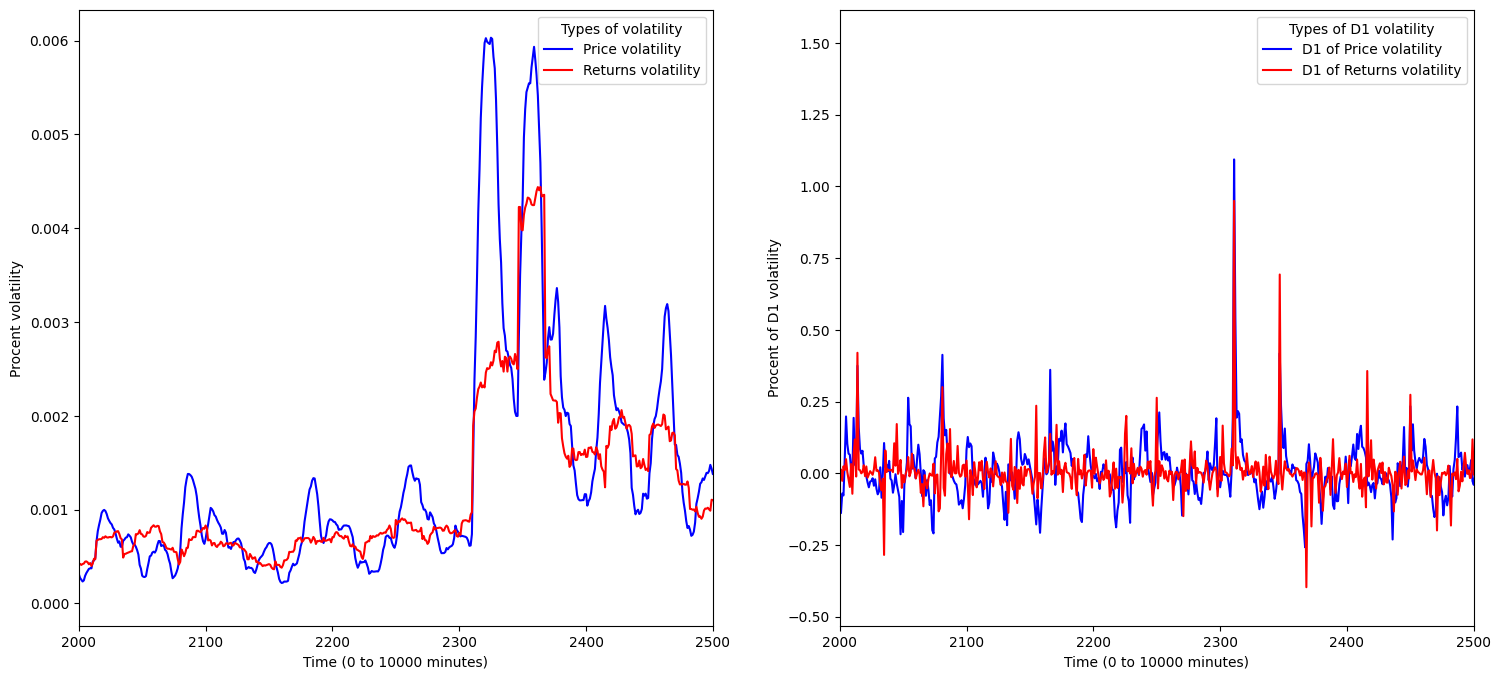

In [121]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

axs[0].plot(btc_1m_df.Pvol/177809, label = "Price volatility", color = "blue")
axs[0].plot(btc_1m_df.Rvol, label = "Returns volatility", color = "red")
#axs[0].suptitle("Price vs Returns vol")
axs[0].set_ylabel("Procent volatility")
axs[0].set_xlabel("Time (0 to 10000 minutes)")
axs[0].legend(title="Types of volatility", loc="upper right")
axs[0].set_xlim(2000,2500)


axs[1].plot(btc_1m_df.DPvol, label = "D1 of Price volatility", color = "blue")
axs[1].plot(btc_1m_df.DRvol, label = "D1 of Returns volatility", color = "red")
#axs[1].suptitle("D1 Price vol vs D1 Returns vol")
axs[1].set_ylabel("Procent of D1 volatility")
axs[1].set_xlabel("Time (0 to 10000 minutes)")
axs[1].legend(title="Types of D1 volatility", loc="upper right")
axs[1].set_xlim(2000,2500)


plt.show()

### K ratio between price vol and returns vol

In [132]:
def calculate_k_ratio(df, column_name='Close', window=20):
    # 1. Flatten MultiIndex if it exists
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(-1)
    
    # 2. Define Position (P) and Velocity (R)
    # Using log-prices to normalize the scale as discussed
    df['P'] = np.log(df[column_name])
    df['R'] = df['P'].diff() # Velocity (change in log-position)
    
    # 3. Calculate Standard Deviation Processes S(P) and S(R)
    df['S_P'] = df['P'].rolling(window=window).std()
    df['S_R'] = df['R'].rolling(window=window).std()
    
    # 4. Calculate k
    # k = S(P) / S(R)
    df['k'] = df['S_P'] / df['S_R']
    
    return df['k'].mean(), df

# Usage
k_value, processed_df = calculate_k_ratio(btc_df)
print(f"Calculated k (Mean): {k_value}")

k_value, processed_df = calculate_k_ratio(btc_1m_df, column_name = "close")
print(f"Calculated k (Mean): {k_value}")

k_value, processed_df = calculate_k_ratio(dal_df)
print(f"Calculated k (Mean): {k_value}")

k_value, processed_df = calculate_k_ratio(dal_1m_df)
print(f"Calculated k (Mean): {k_value}")

Calculated k (Mean): 1.8089570865540272
Calculated k (Mean): 1.6825496163087867
Calculated k (Mean): 1.792699296136987
Calculated k (Mean): 1.6202763849819852


In [133]:
# Calculate k for both granularities
k_m = 1.6825
k_day = 1.80895

# The time ratio (Seconds in an hour = 3600)
time_ratio = 1440
expected_k_ratio = np.sqrt(time_ratio) # Should be ~60

actual_ratio = k_day / k_m

print(f"Expected Ratio (sqrt of time): {expected_k_ratio:.2f}")
print(f"Actual Measured k Ratio:      {actual_ratio:.2f}")

# Error Margin
error = abs(actual_ratio - expected_k_ratio) / expected_k_ratio
print(f"Scaling Law Variance: {error:.2%}")

Expected Ratio (sqrt of time): 37.95
Actual Measured k Ratio:      1.08
Scaling Law Variance: 97.17%


### Autocorrelation

In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as stats


def acf_and_ljungbox(series: pd.Series, lags: int = 40, title: str = "") -> pd.DataFrame:
    """
    Plots ACF and returns Ljung-Box test results (null: no autocorrelation up to each lag).
    """
    s = series.dropna().astype(float)

    fig, ax = plt.subplots(figsize=(9, 4))
    plot_acf(s, lags=lags, ax=ax, zero=False)
    ax.set_title(f"ACF: {title}" if title else "ACF")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Ljung-Box test across lags 1..lags
    lb = acorr_ljungbox(s, lags=list(range(1, lags + 1)), return_df=True)
    # lb has columns: 'lb_stat', 'lb_pvalue'
    return lb


def qq_plot(series: pd.Series, title: str = "") -> None:
    """
    QQ plot vs Normal distribution. Heavy tails show as curved ends / deviations.
    """
    s = series.dropna().astype(float)

    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
    stats.probplot(s, dist="norm", plot=ax)
    ax.set_title(f"QQ plot: {title}" if title else "QQ plot")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def vol_correlations(vol_a: pd.Series, vol_b: pd.Series, name_a="vol_a", name_b="vol_b") -> pd.DataFrame:
    """
    Computes Pearson/Spearman correlations for:
    - levels
    - first differences
    """
    df = pd.concat([vol_a.rename(name_a), vol_b.rename(name_b)], axis=1).dropna()

    # Levels
    pearson_lvl = df[name_a].corr(df[name_b], method="pearson")
    spearman_lvl = df[name_a].corr(df[name_b], method="spearman")

    # First diffs
    dfa = df[name_a].diff()
    dfb = df[name_b].diff()
    ddf = pd.concat([dfa.rename(f"d1_{name_a}"), dfb.rename(f"d1_{name_b}")], axis=1).dropna()

    pearson_d1 = ddf[f"d1_{name_a}"].corr(ddf[f"d1_{name_b}"], method="pearson")
    spearman_d1 = ddf[f"d1_{name_a}"].corr(ddf[f"d1_{name_b}"], method="spearman")

    out = pd.DataFrame(
        {
            "pair": [f"{name_a} vs {name_b}"],
            "pearson_level": [pearson_lvl],
            "spearman_level": [spearman_lvl],
            "pearson_d1": [pearson_d1],
            "spearman_d1": [spearman_d1],
            "n_level": [len(df)],
            "n_d1": [len(ddf)],
        }
    )
    return out


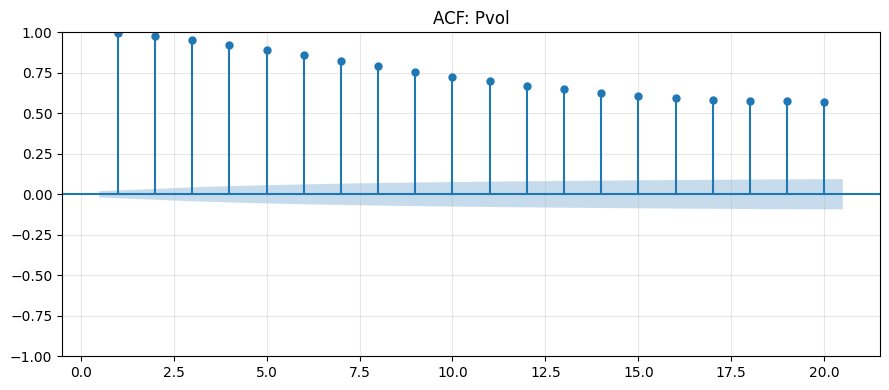

,lb_stat,lb_pvalue
1,10043.188477,0.0
2,19752.222746,0.0
3,28992.147387,0.0
4,37683.457513,0.0
5,45786.939759,0.0
6,53295.121237,0.0
7,60220.167356,0.0
8,66590.757257,0.0
9,72445.680842,0.0
10,77830.468193,0.0


In [143]:
acf_and_ljungbox(series = btc_1m_df["Pvol"], lags = 20, title = "Pvol")

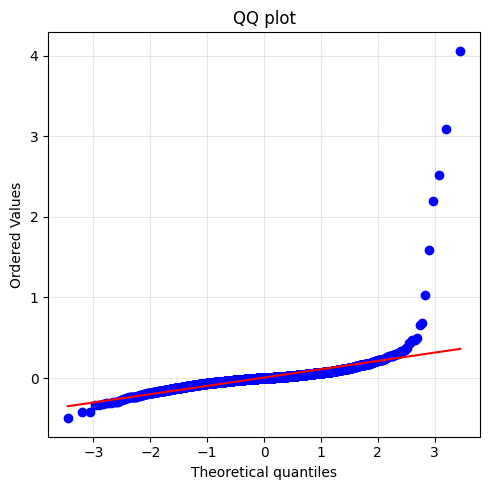

In [138]:
qq_plot(btc_1m_df["DPvol"])
qq_plot(btc_1m_df["DRvol"])

In [142]:
vol_correlations(btc_1m_df["Pvol"], btc_1m_df["Rvol"], name_a="Pvol", name_b="Rvol")

,pair,pearson_level,spearman_level,pearson_d1,spearman_d1,n_level,n_d1
0,Pvol vs Rvol,0.846881,0.845222,0.223276,0.05226,10179,10178


In [141]:
vol_correlations(btc_1m_df["DPvol"], btc_1m_df["DRvol"], name_a="DPvol", name_b="DRvol")

,pair,pearson_level,spearman_level,pearson_d1,spearman_d1,n_level,n_d1
0,DPvol vs DRvol,0.260686,0.063009,0.225811,0.048123,10178,10177


## regime constraining

In [144]:
import numpy as np
import pandas as pd

def lock_extrema_hysteresis(vol: pd.Series,
                            up_thresh: float = 0.15,     # +15% from trough confirms trough
                            down_thresh: float = 0.15,   # -15% from peak confirms peak
                            confirm: int = 3,            # bars that must satisfy condition
                            use_log: bool = True):
    """
    Returns DataFrame with locked local minima/maxima times and values.
    Hysteresis prevents flip-flopping and noise extrema.
    """
    x = vol.astype(float).copy()
    if use_log:
        x = np.log(x.replace(0, np.nan)).dropna()
    else:
        x = x.dropna()

    idx = x.index
    vals = x.values

    locked_min = np.full(len(vals), np.nan)
    locked_max = np.full(len(vals), np.nan)

    state = "seek_min"  # seek_min -> seek_max -> seek_min ...
    cand_i = 0
    cand_val = vals[0]
    streak = 0

    for i in range(1, len(vals)):
        v = vals[i]

        if state == "seek_min":
            # update candidate min
            if v < cand_val:
                cand_val = v
                cand_i = i
                streak = 0

            # confirm trough when moved up enough
            # relative move: (v - cand) / |cand|
            rel_up = (v - cand_val) / (abs(cand_val) + 1e-12)
            if rel_up >= up_thresh:
                streak += 1
            else:
                streak = 0

            if streak >= confirm:
                locked_min[cand_i] = cand_val
                state = "seek_max"
                cand_i = i
                cand_val = v
                streak = 0

        else:  # seek_max
            # update candidate max
            if v > cand_val:
                cand_val = v
                cand_i = i
                streak = 0

            rel_down = (cand_val - v) / (abs(cand_val) + 1e-12)
            if rel_down >= down_thresh:
                streak += 1
            else:
                streak = 0

            if streak >= confirm:
                locked_max[cand_i] = cand_val
                state = "seek_min"
                cand_i = i
                cand_val = v
                streak = 0

    out = pd.DataFrame(index=idx)
    out["x"] = vals
    out["locked_min"] = locked_min
    out["locked_max"] = locked_max

    if use_log:
        # optional: convert locked values back to vol scale
        out["locked_min_vol"] = np.exp(out["locked_min"])
        out["locked_max_vol"] = np.exp(out["locked_max"])

    return out


In [160]:
a = lock_extrema_hysteresis(btc_df["Close"])
a

,x,locked_min,locked_max,locked_min_vol,locked_max_vol
Date,,,,,
2014-09-17,6.125414,NaN,NaN,NaN,NaN
2014-09-18,6.050771,NaN,NaN,NaN,NaN
2014-09-19,5.978369,NaN,NaN,NaN,NaN
2014-09-20,6.013480,NaN,NaN,NaN,NaN
2014-09-21,5.988513,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2024-12-27,11.452802,NaN,NaN,NaN,NaN
2024-12-28,11.463356,NaN,NaN,NaN,NaN
2024-12-29,11.446040,NaN,NaN,NaN,NaN


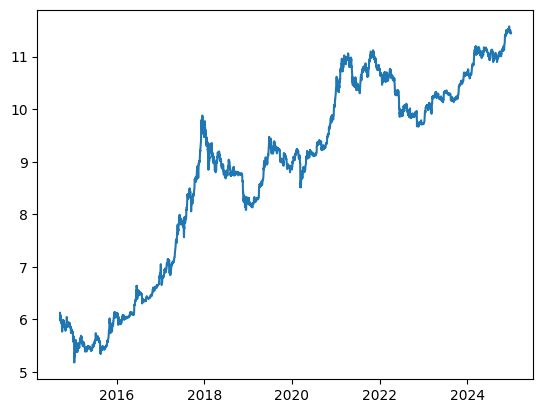

In [161]:
plt.plot(a["x"])

In [149]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks

def extrema_prominence(vol: pd.Series,
                       smooth_span: int = 20,
                       prominence: float = 0.2,
                       distance: int = 10,
                       use_log: bool = True):
    x = vol.astype(float).copy()
    if use_log:
        x = np.log(x.replace(0, np.nan))
    x = x.dropna()

    # Smooth (EMA)
    xs = x.ewm(span=smooth_span, adjust=False).mean().values

    peaks, _ = find_peaks(xs, prominence=prominence, distance=distance)
    troughs, _ = find_peaks(-xs, prominence=prominence, distance=distance)

    out = pd.DataFrame(index=x.index)
    out["x_smooth"] = xs
    out["is_peak"] = False
    out["is_trough"] = False
    out.loc[out.index[peaks], "is_peak"] = True
    out.loc[out.index[troughs], "is_trough"] = True
    return out


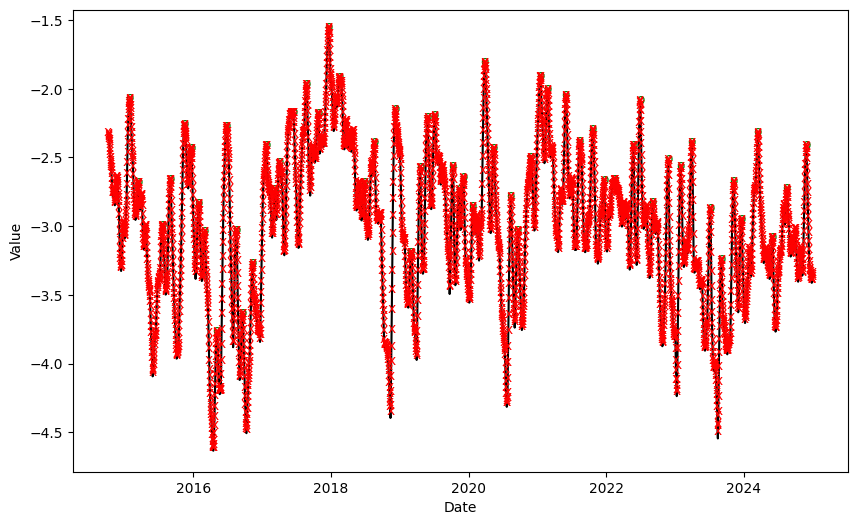

In [159]:
b = extrema_prominence(btc_df["Pvol"])
b

b['long_signal'] = (b["is_peak"] == True) #& (df["signal"] == "Buy") #& (df["MA_buy"] == True)
# Generate short (sell) signals
b['short_signal'] = (b["is_trough"] == False) #& (df["signal"] == "Sell") # & (df["MA_sell"] == True)

fig, ax = plt.subplots(figsize=(10, 6))

# Add arrows for long (buy) signals
long_signal_dates = b[b['long_signal']].index
for date in long_signal_dates:
    ax.annotate('o', xy=(date, b.loc[date, 'x_smooth']), color='green', fontsize=10, ha='center')

# Add arrows for short (sell) signals
short_signal_dates = b[b['short_signal']].index
for date in short_signal_dates:
    ax.annotate('x', xy=(date, b.loc[date, 'x_smooth']), color='red', fontsize=10, ha='center')

# Plot the time series
plt.plot(b.x_smooth, color = "Black")
plt.xlabel('Date')
plt.ylabel('Value')
#plt.xlim(2500,3500)
#plt.ylim(0,20)
plt.show()
#plt.plot(b["x_smooth"])

In [155]:
# pip install ruptures
import numpy as np
import pandas as pd
import ruptures as rpt

def changepoints(vol: pd.Series, model="rbf", pen=10, use_log=True):
    x = vol.astype(float).replace(0, np.nan).dropna()
    if use_log:
        x = np.log(x)
    signal = x.values.reshape(-1, 1)

    algo = rpt.Pelt(model=model).fit(signal)
    bkps = algo.predict(pen=pen)  # indices of segment ends

    out = pd.DataFrame(index=x.index)
    out["x"] = x.values
    out["segment"] = 0
    seg = 0
    start = 0
    for end in bkps:
        out.iloc[start:end, out.columns.get_loc("segment")] = seg
        seg += 1
        start = end
    return out, bkps


In [156]:
changepoints(btc_df["Pvol"])

(                   x  segment
 Date                         
 2014-10-07 -2.338794        0
 2014-10-08 -2.409050        0
 2014-10-09 -2.444147        0
 2014-10-10 -2.444757        0
 2014-10-11 -2.464934        0
 ...              ...      ...
 2024-12-27 -3.377615       52
 2024-12-28 -3.343659       52
 2024-12-29 -3.295683       52
 2024-12-30 -3.232474       52
 2024-12-31 -3.196155       52
 
 [3739 rows x 2 columns],
 [100,
  120,
  205,
  255,
  315,
  335,
  380,
  445,
  530,
  600,
  640,
  810,
  940,
  985,
  1015,
  1150,
  1175,
  1305,
  1450,
  1500,
  1550,
  1615,
  1640,
  1890,
  1920,
  1985,
  2000,
  2050,
  2080,
  2120,
  2140,
  2205,
  2265,
  2335,
  2790,
  2805,
  2825,
  2920,
  2955,
  2975,
  3020,
  3100,
  3180,
  3195,
  3235,
  3255,
  3305,
  3320,
  3415,
  3450,
  3690,
  3705,
  3739])